In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [3]:
from matplotlib.pylab import rcParams

In [4]:
import matplotlib

In [5]:
pd.plotting.register_matplotlib_converters()


In [6]:
df = pd.read_csv('2018_2019.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3429002 entries, 0 to 3429001
Data columns (total 14 columns):
Unnamed: 0        int64
date              object
train_id          object
stop_sequence     float64
from              object
from_id           float64
to                object
to_id             float64
scheduled_time    object
actual_time       object
delay_minutes     float64
status            object
line              object
type              object
dtypes: float64(4), int64(1), object(9)
memory usage: 366.3+ MB


In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [9]:
df.tail()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
3428997,2019-04-30,1629,5.0,Nanuet,100.0,Spring Valley,142.0,2019-04-30 18:25:00,2019-04-30 18:27:00,2.0,estimated,Pascack Valley,NJ Transit
3428998,2019-04-30,A2124,NaN,Philadelphia,1.0,Philadelphia,1.0,NaN,2019-04-30 19:28:49,NaN,departed,ACELA EXPRESS,Amtrak
3428999,2019-04-30,A2124,NaN,Philadelphia,1.0,Metropark,83.0,NaN,2019-04-30 20:16:23,NaN,departed,ACELA EXPRESS,Amtrak
3429000,2019-04-30,A2124,NaN,Metropark,83.0,Newark Penn Station,107.0,NaN,2019-04-30 20:30:53,NaN,departed,ACELA EXPRESS,Amtrak
3429001,2019-04-30,A2124,NaN,Newark Penn Station,107.0,New York Penn Station,105.0,NaN,2019-04-30 20:49:04,NaN,departed,ACELA EXPRESS,Amtrak


In [10]:
df.index

RangeIndex(start=0, stop=3429002, step=1)

In [11]:
len(df)

3429002

In [12]:
df.isnull().sum()

date                   0
train_id               0
stop_sequence     278718
from                   0
from_id              891
to                     0
to_id                891
scheduled_time    278718
actual_time            0
delay_minutes     278718
status                 0
line                   0
type                   0
dtype: int64

# To Prophet friendly format

In [13]:
df= df.rename(columns={'date':'ds',
                     'delay_minutes':'y'})

df.head()

,ds,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,y,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [14]:
# df_prophet = df.drop(df[['stop_sequence', 'from_id', 'to_id']], axis=1)

In [15]:
df = df.dropna(axis=0, subset=['y'])
df.isnull().sum()

ds                  0
train_id            0
stop_sequence       0
from                0
from_id           883
to                  0
to_id               0
scheduled_time      0
actual_time         0
y                   0
status              0
line                0
type                0
dtype: int64

In [16]:
df = df.dropna(axis=0, subset=['from_id'])

df.isnull().sum()

ds                0
train_id          0
stop_sequence     0
from              0
from_id           0
to                0
to_id             0
scheduled_time    0
actual_time       0
y                 0
status            0
line              0
type              0
dtype: int64

In [17]:
len(df)

3149401

# Converting ds to datetime and setting as index

In [18]:
df['ds'] = pd.to_datetime(df['ds'])
df.dtypes

ds                datetime64[ns]
train_id                  object
stop_sequence            float64
from                      object
from_id                  float64
to                        object
to_id                    float64
scheduled_time            object
actual_time               object
y                        float64
status                    object
line                      object
type                      object
dtype: object

In [19]:
df.y.value_counts().sort_index()

0.000000      403759
0.016667        6640
0.033333        9768
0.050000       12445
0.066667       14764
               ...  
153.133333         1
162.000000         2
163.000000         1
325.000000         4
326.000000         2
Name: y, Length: 4543, dtype: int64

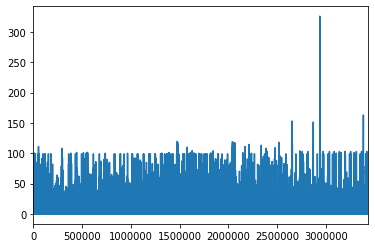

In [20]:
df['y'].plot()

In [21]:
df.loc[df['y'] < np.percentile(df['y'],95)]

,ds,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,y,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428993,2019-04-30,1629,1.0,Hoboken,63.0,Hoboken,63.0,2019-04-30 17:32:00,2019-04-30 17:32:14,0.233333,departed,Pascack Valley,NJ Transit
3428994,2019-04-30,1629,2.0,Hoboken,63.0,Secaucus Lower Lvl,38174.0,2019-04-30 17:43:00,2019-04-30 17:46:00,3.000000,departed,Pascack Valley,NJ Transit
3428995,2019-04-30,1629,3.0,Secaucus Lower Lvl,38174.0,Pearl River,118.0,2019-04-30 18:14:00,2019-04-30 18:17:59,3.983333,departed,Pascack Valley,NJ Transit
3428996,2019-04-30,1629,4.0,Pearl River,118.0,Nanuet,100.0,2019-04-30 18:20:00,2019-04-30 18:23:41,3.683333,departed,Pascack Valley,NJ Transit


# Resampling for a smaller dataframe for Prophet to work on

In [22]:
df = df.set_index('ds')
df_daily = df.resample(rule="D").sum()

df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2018-03-01 to 2019-04-30
Freq: D
Data columns (total 4 columns):
stop_sequence    426 non-null float64
from_id          426 non-null float64
to_id            426 non-null float64
y                426 non-null float64
dtypes: float64(4)
memory usage: 16.6 KB


# Plot of time series of delays

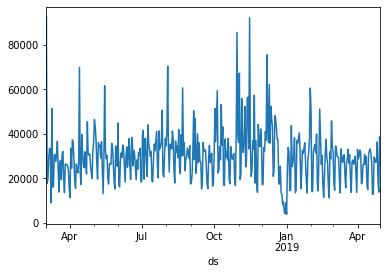

In [23]:
df_daily['y'].plot()

In [24]:
df_no_zero =df_daily[df_daily.y != 0]

In [25]:
df_no_zero.head()

,stop_sequence,from_id,to_id,y
ds,,,,
2018-03-01,74474.0,40126496.0,40295792.0,38248.733333
2018-03-02,78222.0,41589519.0,41689096.0,92729.650000
2018-03-03,40376.0,21256242.0,21408303.0,17608.116667
2018-03-04,39729.0,21061529.0,21176086.0,19506.866667
2018-03-05,77932.0,41403529.0,41572733.0,28857.733333


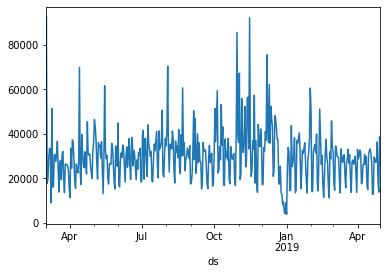

In [26]:
df_no_zero['y'].plot()

plt.show()

# Decomposition

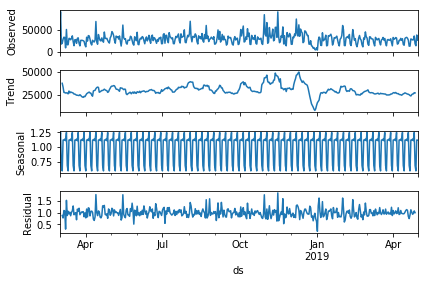

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_no_zero['y'], model='mul')
ax = result.plot()

In [28]:
split_date = '2018-09-02' #or -01
df_train = df_no_zero.loc[df_no_zero.index <= split_date].copy()
df_test = df_no_zero.loc[df_no_zero.index > split_date].copy()

In [29]:
df_train = df_train.reset_index()

df_train.head()

,ds,stop_sequence,from_id,to_id,y
0,2018-03-01,74474.0,40126496.0,40295792.0,38248.733333
1,2018-03-02,78222.0,41589519.0,41689096.0,92729.650000
2,2018-03-03,40376.0,21256242.0,21408303.0,17608.116667
3,2018-03-04,39729.0,21061529.0,21176086.0,19506.866667
4,2018-03-05,77932.0,41403529.0,41572733.0,28857.733333


In [30]:
df_test = df_test.reset_index()

df_test.head()

,ds,stop_sequence,from_id,to_id,y
0,2018-09-03,41719.0,21829588.0,21943549.0,21546.716667
1,2018-09-04,75487.0,40456450.0,40549263.0,32808.833333
2,2018-09-05,70759.0,38174097.0,38305000.0,50356.766667
3,2018-09-06,72060.0,38221578.0,38351834.0,28335.300000
4,2018-09-07,70895.0,38366030.0,38421343.0,46922.900000


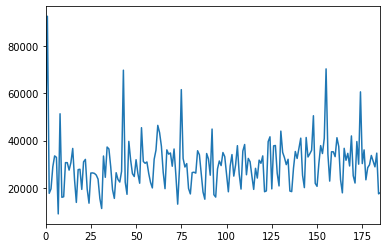

In [31]:
df_train['y'].plot()

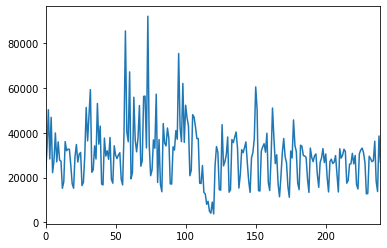

In [32]:
df_test['y'].plot()

In [33]:
len(df_train)

186

# Simple/naive Prophet model

In [34]:
# Setup and train model and fit
model = Prophet()
model.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/michael/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [35]:
df_test_fcst = model.predict(df_test)

# Prophet Plotting

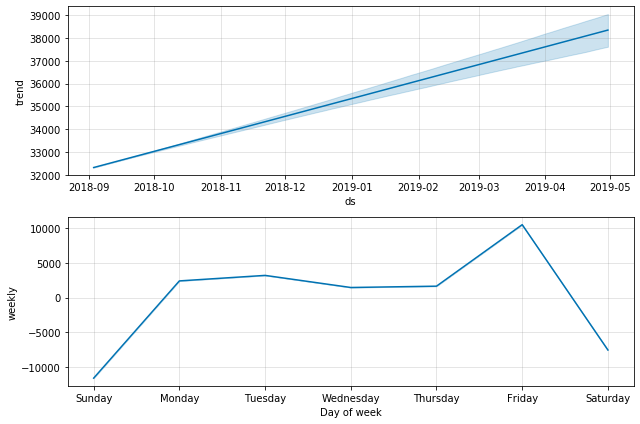

In [36]:
fig = model.plot_components(df_test_fcst)

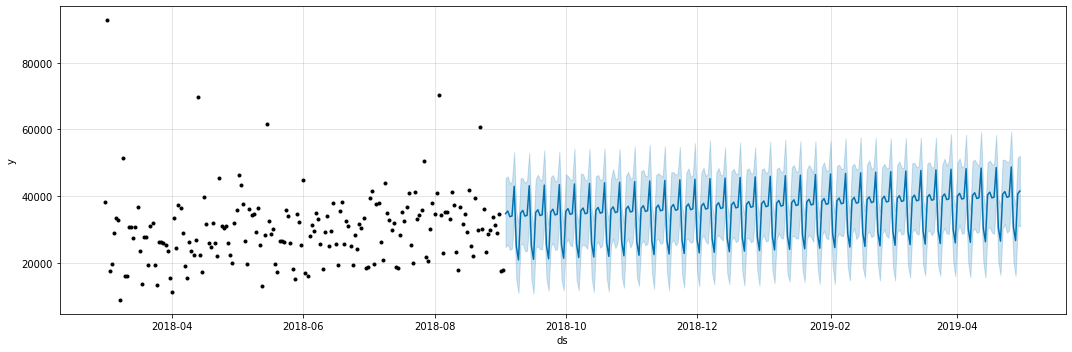

In [37]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

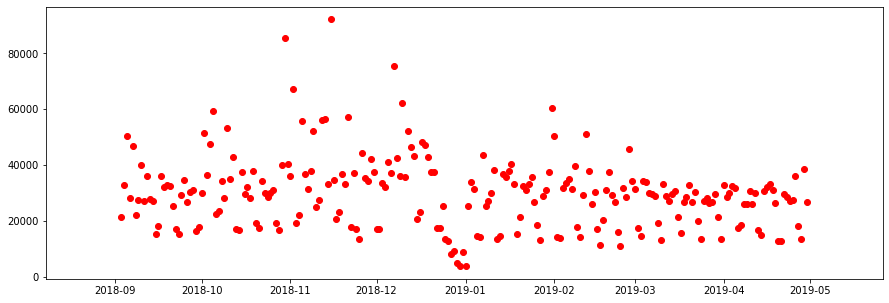

In [38]:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test['ds'], df_test['y'], color='r')

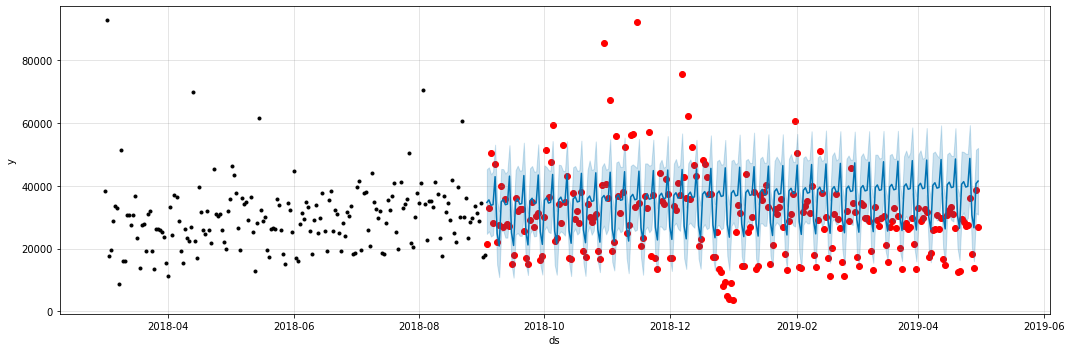

In [39]:
fig = model.plot(df_test_fcst, ax=ax)

fig

In [40]:
mean_squared_error(y_true=df_test['y'],
                   y_pred=df_test_fcst['yhat'])


155483269.1401251

In [41]:
mean_absolute_error(y_true=df_test['y'],
                   y_pred=df_test_fcst['yhat'])


9900.890437844268

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['y'],
                   y_pred=df_test_fcst['yhat'])

48.01607792081947

# This is a rather sorry MAPE, time to look into tweaking the model and other models(XGBoost for example.)

# XGBoost model for comparison

In [43]:
df_train = df_train.set_index('ds')

In [44]:
df_test = df_test.set_index('ds')

In [45]:
X_train = df_train.drop('y', axis=1)

In [46]:
y_train = df_train['y']

In [47]:
X_test = df_test.drop('y', axis=1)

In [48]:
y_test = df_test['y']

In [49]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/Users/michael/anaconda3/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/michael/anaconda3/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

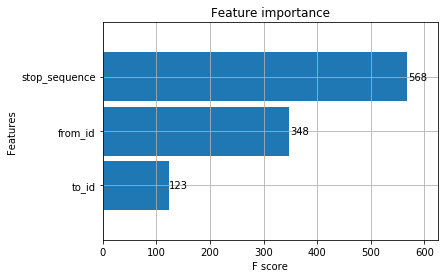

In [50]:
_ = plot_importance(reg, height=0.9)

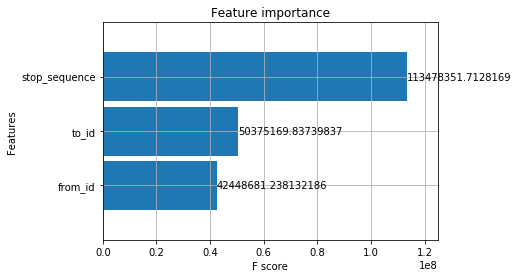

In [51]:
_ = plot_importance(reg, height=0.9, importance_type="gain")

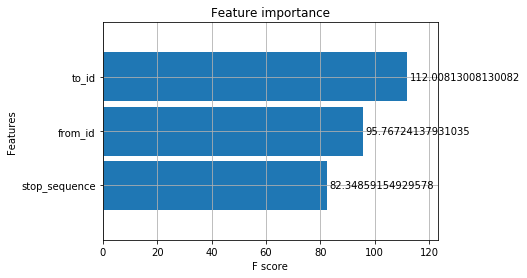

In [52]:
_ = plot_importance(reg, height=0.9, importance_type="cover")

In [53]:
rcParams['figure.figsize'] = 80,50

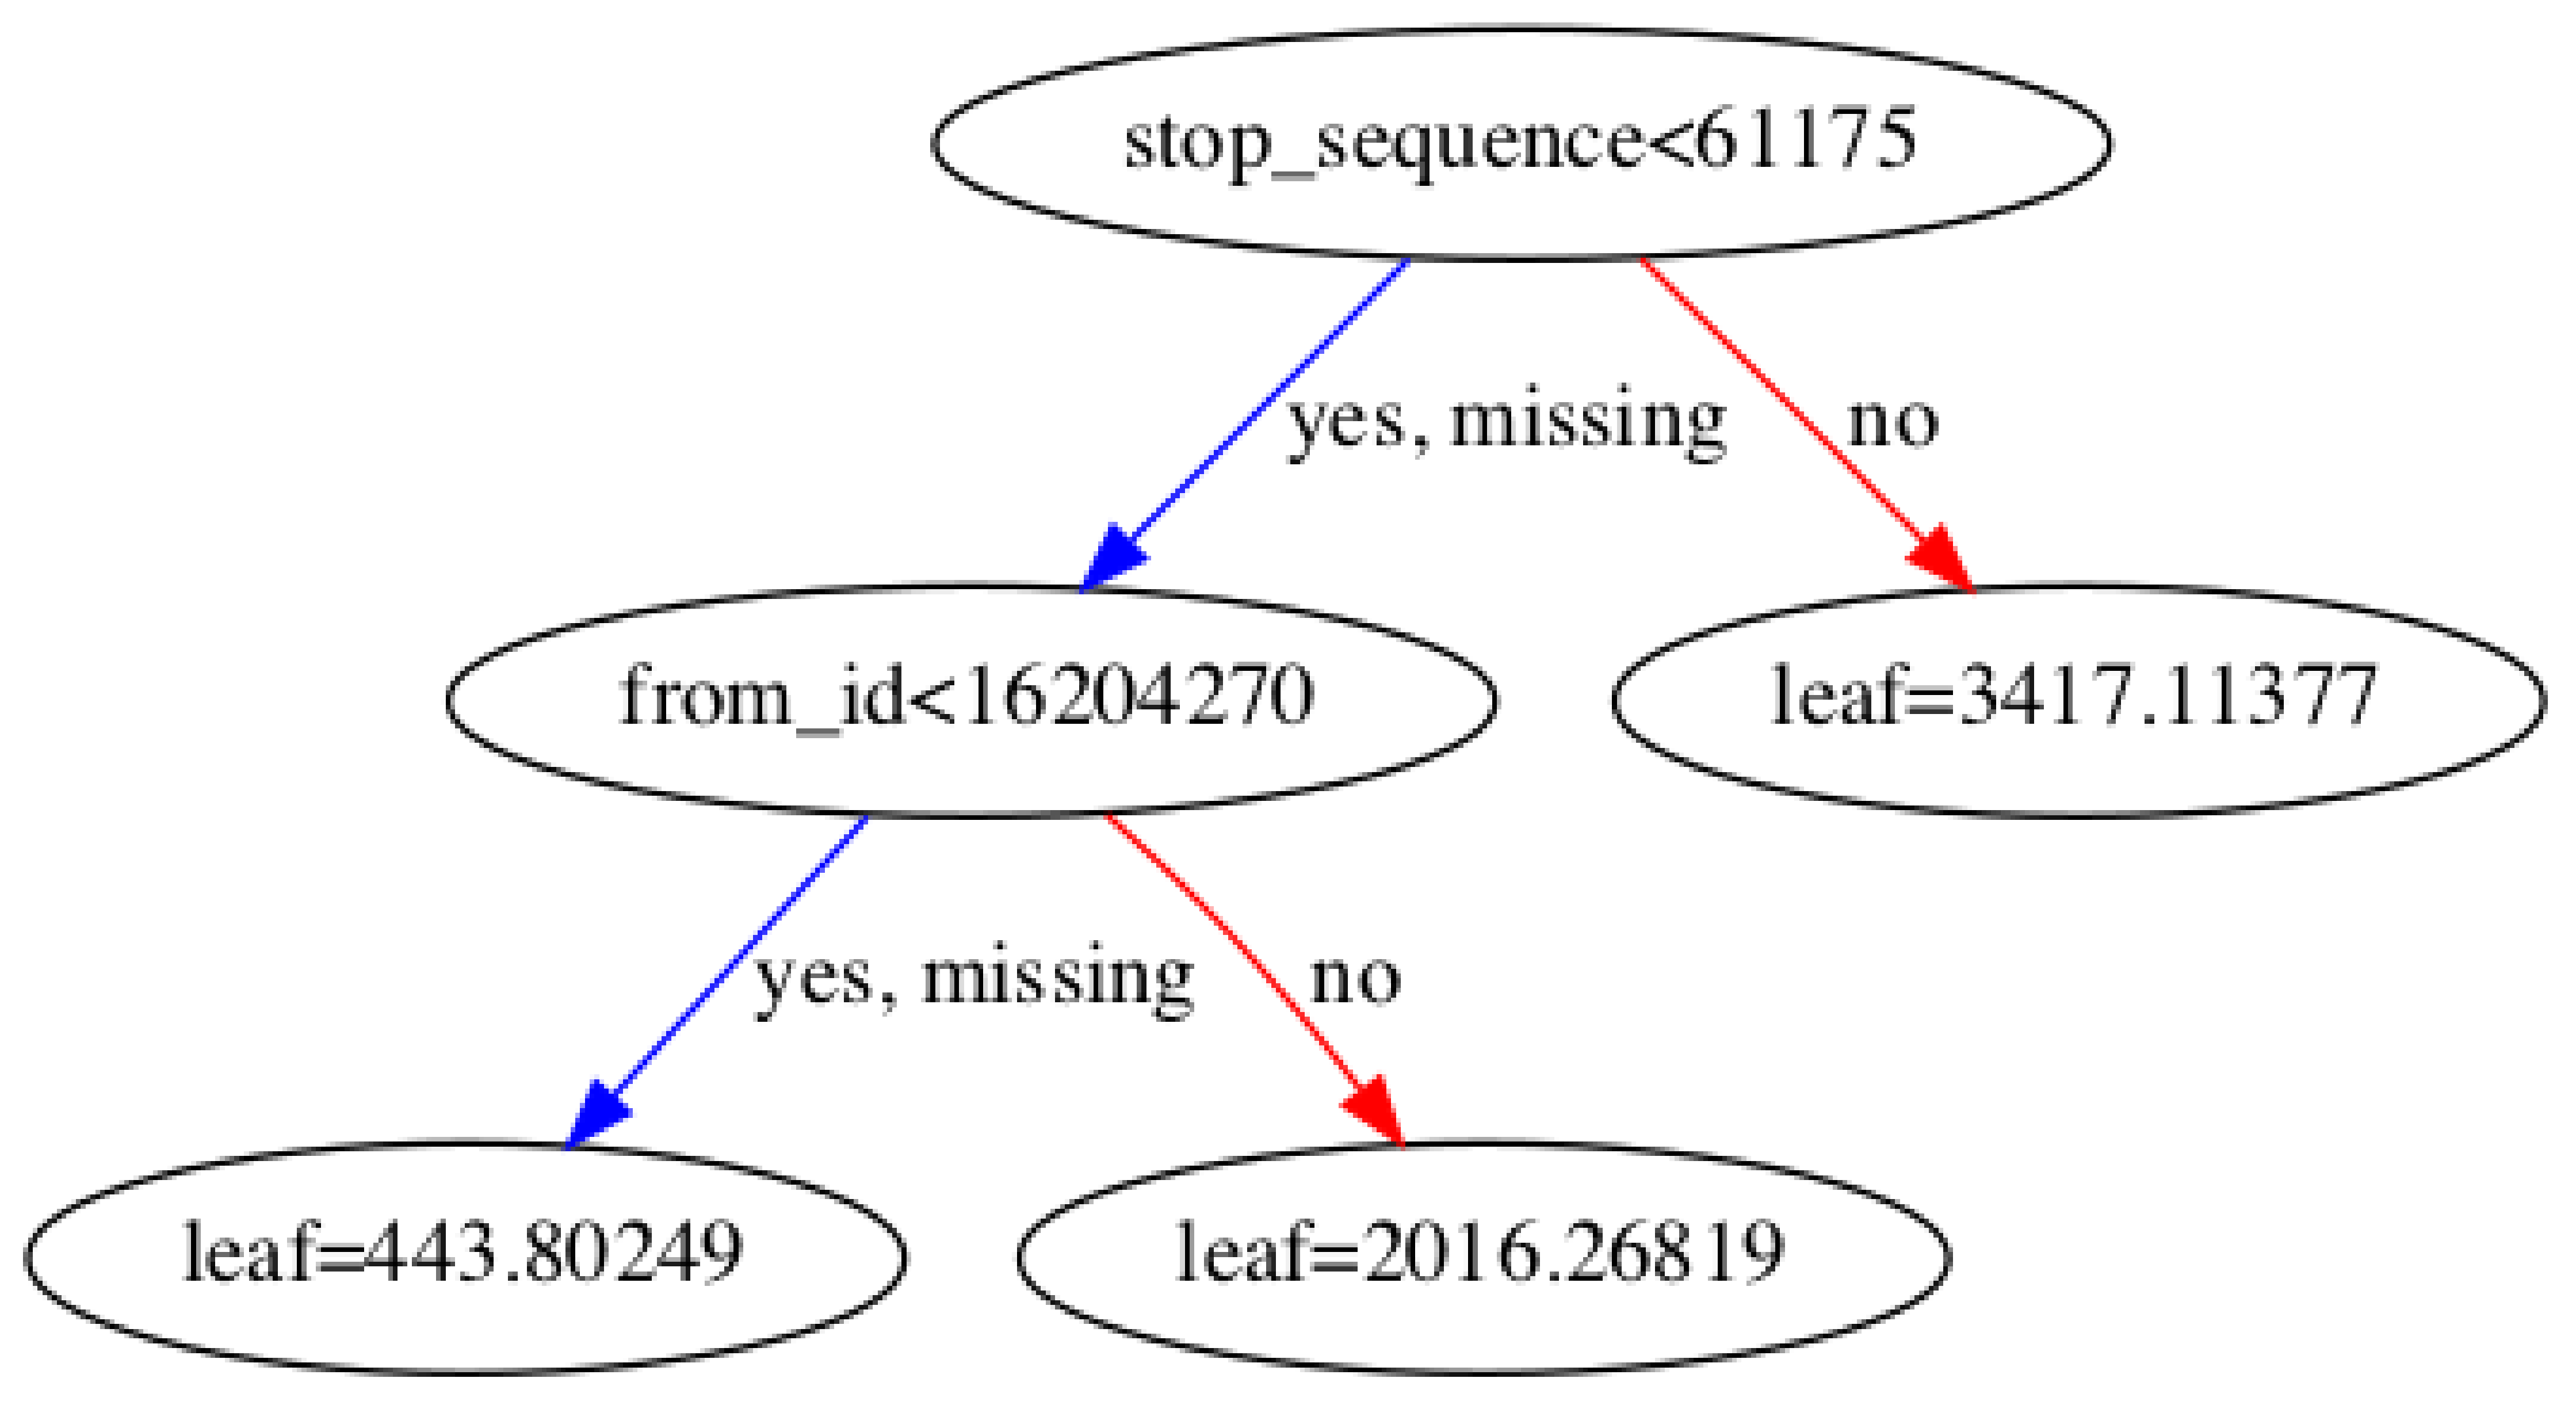

In [54]:
plot_tree(reg)

In [55]:
df_test['Delay_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

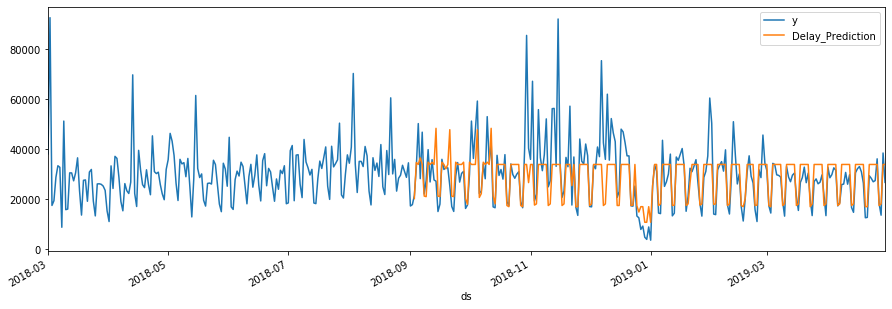

In [56]:
_ = df_all[['y','Delay_Prediction']].plot(figsize=(15, 5))

In [57]:
mean_absolute_percentage_error(y_true=df_test['y'],
                   y_pred=df_test['Delay_Prediction'])

20.753507546442755

In [58]:
df.columns

Index(['train_id', 'stop_sequence', 'from', 'from_id', 'to', 'to_id',
       'scheduled_time', 'actual_time', 'y', 'status', 'line', 'type'],
      dtype='object')

In [59]:
df.index

DatetimeIndex(['2018-03-01', '2018-03-01', '2018-03-01', '2018-03-01',
               '2018-03-01', '2018-03-01', '2018-03-01', '2018-03-01',
               '2018-03-01', '2018-03-01',
               ...
               '2019-04-30', '2019-04-30', '2019-04-30', '2019-04-30',
               '2019-04-30', '2019-04-30', '2019-04-30', '2019-04-30',
               '2019-04-30', '2019-04-30'],
              dtype='datetime64[ns]', name='ds', length=3149401, freq=None)

In [60]:
split_date = '2018-09-02' #or -01
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [61]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [62]:
X_train, y_train = create_features(df_train, label='y')
X_test, y_test = create_features(df_test, label='y')

In [63]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/Users/michael/anaconda3/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/michael/anaconda3/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [64]:
matplotlib.rcdefaults() 

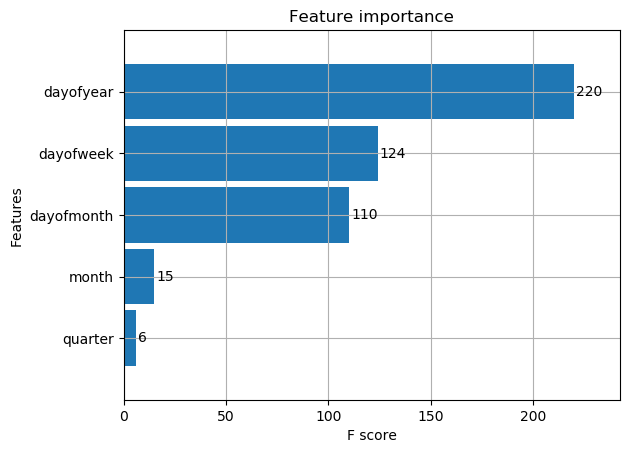

In [65]:
_ = plot_importance(reg, height=0.9)

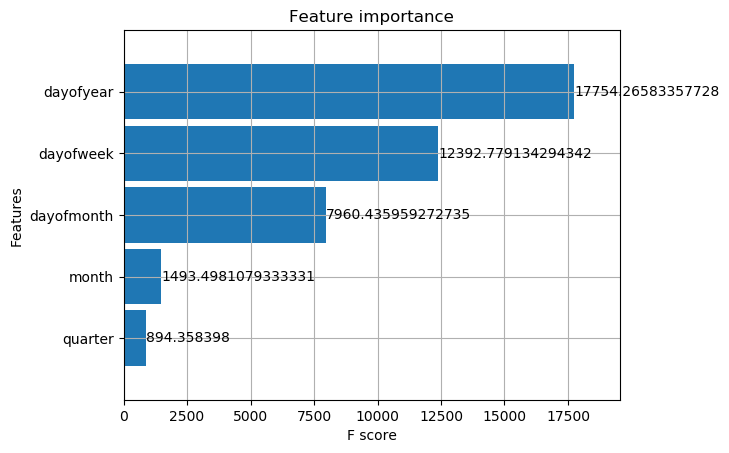

In [66]:
_ = plot_importance(reg, height=0.9, importance_type="gain")

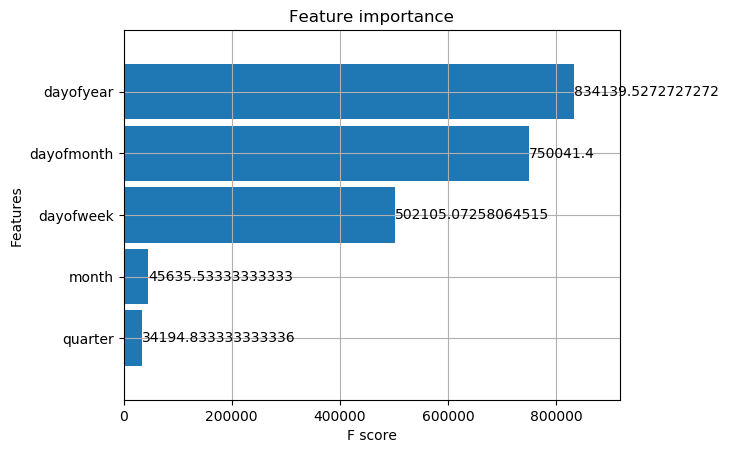

In [67]:
_ = plot_importance(reg, height=0.9, importance_type="cover")

In [68]:
df_test['Delay_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [69]:
rcParams['figure.figsize'] = 80,50

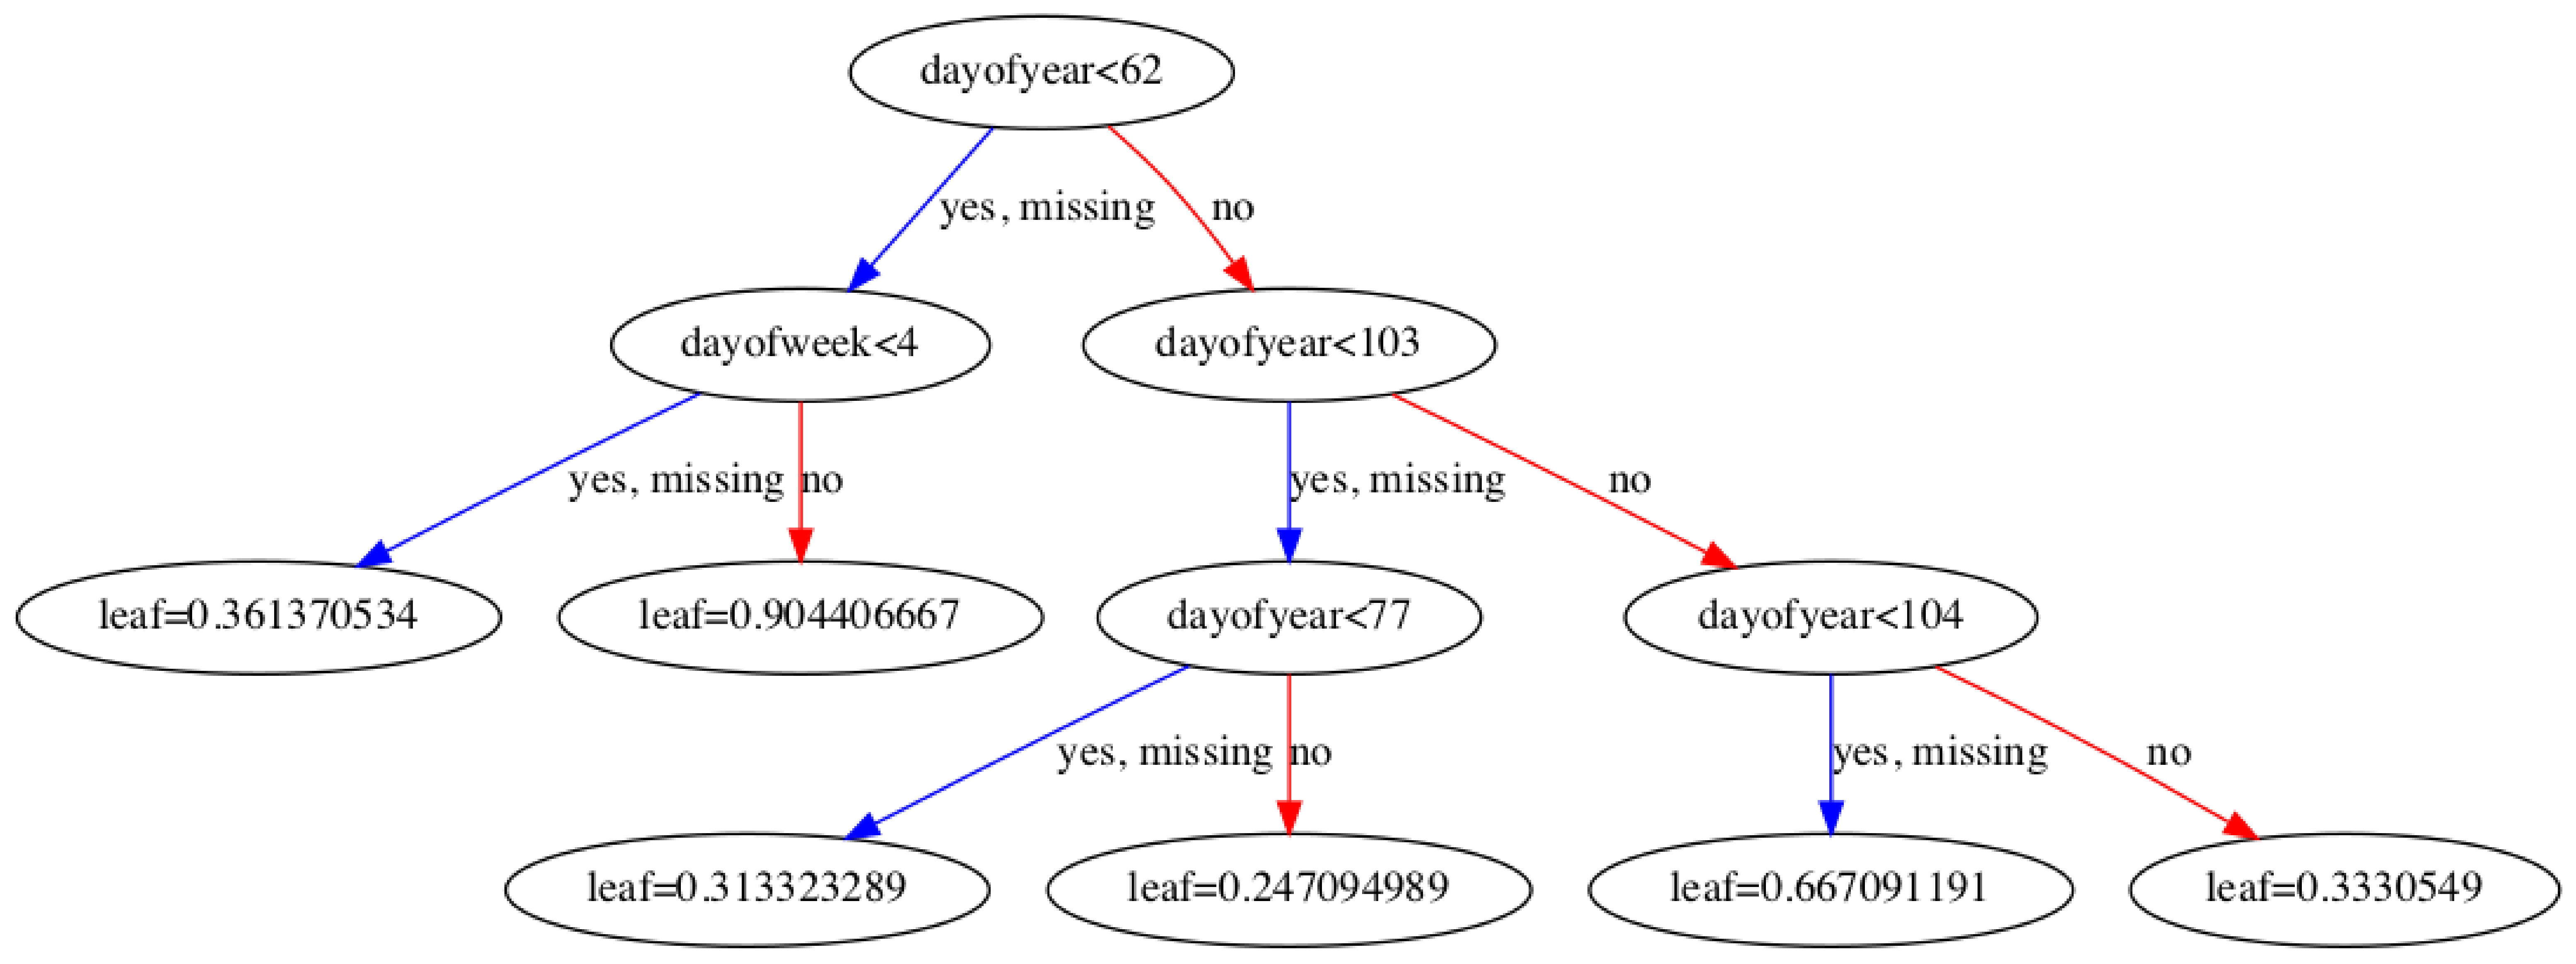

In [70]:
plot_tree(reg)

In [71]:
matplotlib.rcdefaults() 

In [74]:
# _ = df_all[['y','Delay_Prediction']].plot(figsize=(20, 10)) !? !? 